In [13]:
# import sys
# sys.path.append('.')

In [14]:
from utils import dump_jsonl, load_jsonl, CLOSENESS_LABELS, AUTHORITY_LABELS
import pandas as pd
import numpy as np

## Task1

In [15]:
data = load_jsonl("./Task1/annotated_conersations.jsonl")

Loaded 1234 records from ./Task1/annotated_conersations.jsonl


In [16]:
data = pd.DataFrame(data)

In [17]:
# data = data[~pd.isna(data["relationship"])]

In [18]:
import matplotlib.pyplot as plt
def bar_plot(labels, values, figname=None, as_percentage=True):
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    if as_percentage:
        norm = sum(values)
        values = [v*100/norm for v in values]
        bar_labels = [f"{v:.2f}%" for v in values]
        plt.ylim([0, 100])
    else:
        bar_labels = [f"{v:.2f}" for v in values]
    bars = ax.bar(labels, values)
    
    
    ax.bar_label(bars, labels=bar_labels)
    
    plt.xticks(rotation=30, ha='right')
    if figname is not None:
        plt.savefig(f'{figname}.png', bbox_inches='tight', dpi=150)
        plt.savefig(f'{figname}.pdf', bbox_inches='tight', dpi=150)
    plt.show()
    
    

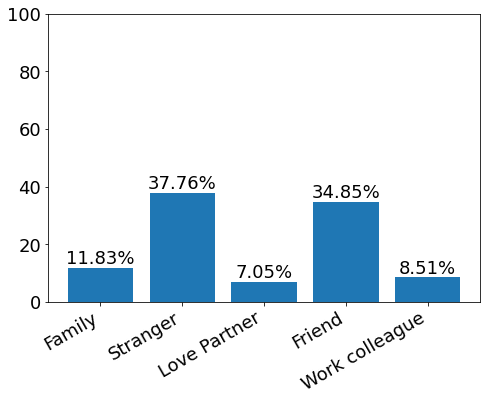

In [19]:
rel_maps = {
    'คนในครอบครัว (Family)': 'Family',
    'คนไม่รู้จัก (Stranger)': 'Stranger',
    'คู่รัก (Love Partner)': 'Love Partner',
    'เพื่อน (Friend)': 'Friend',
    'เพื่อนร่วมงาน (Work colleague)': 'Work colleague',
}

cnt = data.groupby("relationship").count()
labels = [rel_maps[rel] for rel in cnt.index]
values = cnt["topic"].values*100/len(data)
bar_plot(labels, values, figname="Figures/task1-relationship")

In [20]:
data.authority.unique()

array(['1. Respect', '0. Very respect', '2. Normal', None,
       '3. Not respect'], dtype=object)

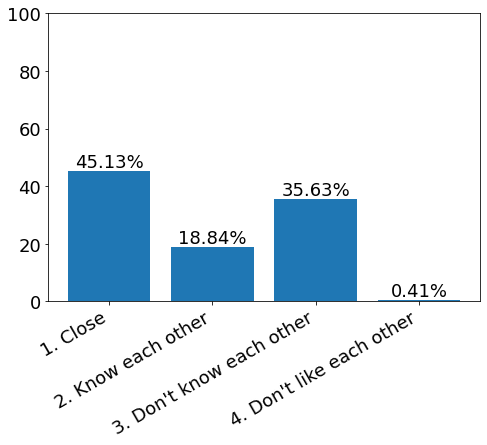

In [21]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["topic"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task1-close")

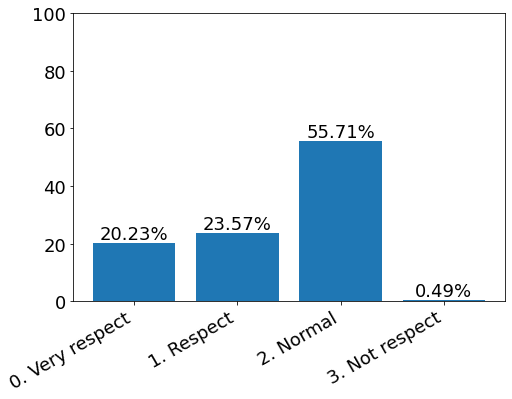

In [22]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["topic"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task1-auth")

#### Closeness/Respect Correlation

In [23]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_heatmap(xlabel, ylabel, mat, title=""):

    fig, ax = plt.subplots()
    im = ax.imshow(mat)

    # Show all ticks and label them with the respective list entries
    ax.set_xticklabels(xlabel)
    ax.set_yticklabels(ylabel)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # Loop over data dimensions and create text annotations.
    for i in range(len(xlabel)):
        for j in range(len(ylabel)):
            text = ax.text(j, i, f"{mat[i, j]:.3f}", ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [24]:
mat = []
for clos in CLOSENESS_LABELS:
    row = []
    for auth in AUTHORITY_LABELS:
        p_clos = (data["closeness"]==clos).sum()/len(data)
        p_auth = (data["authority"]==auth).sum()/len(data)
        
        d = data
        d = d[d["closeness"]==clos]
        d = d[d["authority"]==auth]
        p_clos_auth = len(d)/len(data)
        
        pmi = np.log2(p_clos_auth/(p_clos*p_auth))
        row.append(pmi)
    mat.append(row)
# plot_heatmap(CLOSENESS_LABELS, AUTHORITY_LABELS, np.array(mat))

In [25]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score

In [26]:
d = data.dropna()
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.01550967924866547

Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement.

## Task 2

In [27]:
data = load_jsonl("./Task2/annotated/annotated.jsonl")

Loaded 2486 records from ./Task2/annotated/annotated.jsonl


In [28]:
data = pd.DataFrame(data)

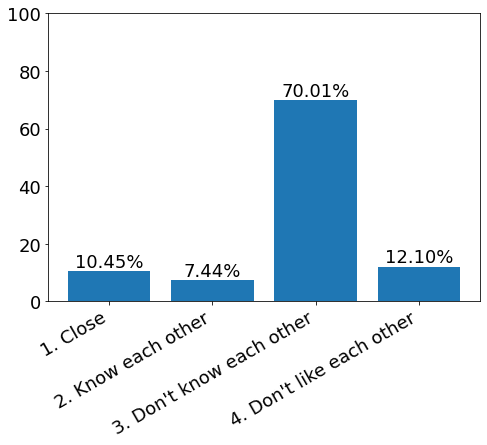

In [29]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["text"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task2-clos")

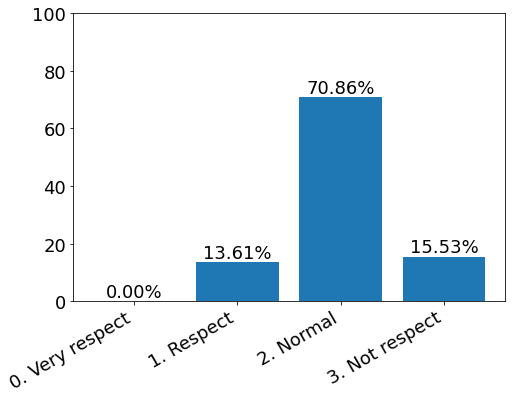

In [30]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["text"][c] if c in cnt["text"] else 0 for c in labels ]
bar_plot(labels, values, figname="Figures/task2-auth")

In [31]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
data = data[~pd.isna(data["closeness"])]
data = data[~pd.isna(data["authority"])]

d = data
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.23693749738451444

## Task 3

In [32]:
data = load_jsonl("./Task3/annotated/annotated.jsonl")
data = pd.DataFrame(data)

Loaded 1221 records from ./Task3/annotated/annotated.jsonl


In [33]:
# data

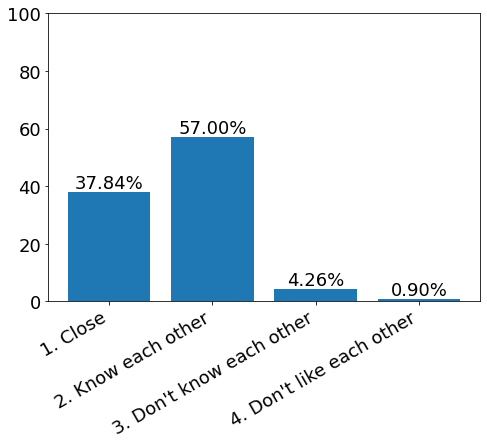

In [34]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["messages"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task3-clos")

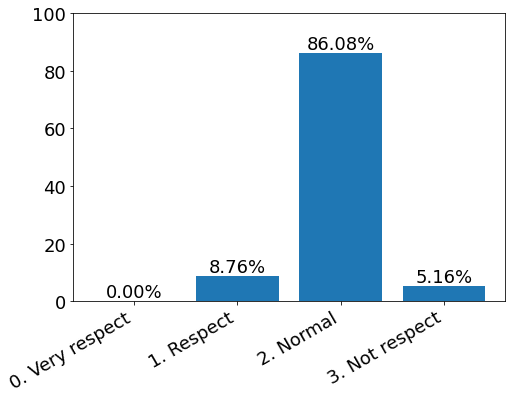

In [35]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["messages"][c] if c in cnt["messages"] else 0 for c in labels ]
bar_plot(labels, values, figname="Figures/task3-auth")

In [36]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
data = data[~pd.isna(data["closeness"])]
data = data[~pd.isna(data["authority"])]

d = data
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.13603079920760636

#### Agreement between self-reported and percieved

In [37]:
data1 = load_jsonl("./Task1/annotated_conersations.jsonl")
data1 = pd.DataFrame(data1)

Loaded 1234 records from ./Task1/annotated_conersations.jsonl


In [38]:
data3 = load_jsonl("./Task3/annotated/annotated.jsonl")
data3 = pd.DataFrame(data3)

Loaded 1221 records from ./Task3/annotated/annotated.jsonl


In [39]:
from collections import defaultdict

# ordinal_weights
def get_weights(categories):
    weights = defaultdict(dict)
    if len(categories)==3:
        mat = [[1.00, 0.67, 0.00], 
               [0.67, 1.00, 0.67], 
               [0.00, 0.67, 1.00]]
    elif len(categories)==4:
        mat = [[1.00, 0.83, 0.50, 0.00], 
               [0.83, 1.00, 0.83, 0.50], 
               [0.50, 0.83, 1.00, 0.83], 
               [0.00, 0.50, 0.83, 1.00]]
    elif len(categories)==5:
        mat = [[1, 0.9, 0.7, 0.4, 0.0], 
               [0.9, 1, 0.9, 0.7, 0.4], 
               [0.7, 0.9, 1, 0.9, 0.7], 
               [0.4, 0.7, 0.9, 1, 0.9],
               [0.0, 0.4, 0.7, 0.9, 1]]
    else:
        # Lazy to implement in case of len(categories) > 5
        raise Exception("No Implementation")
        
    for i, l in enumerate(categories): 
        for j, k in enumerate(categories): 
            weights[l][k] = mat[i][j]
    return weights

    
def cal_agreement(df1, df2, column, categories, cat_column):
    merged = pd.merge(df1, df2, on=column)
#     assert(len(df1)==len(merged))
    merged = merged.dropna()    
    cnt_matrix = defaultdict(dict)
    acc_matrix = defaultdict(dict)
    
    for l in categories: 
        for k in categories: 
            d = merged
            d = d[d[f"{cat_column}_x"]==k]
            d = d[d[f"{cat_column}_y"]==l]
            cnt_matrix[l][k] = len(d)
    
    for l in categories: 
        d = merged
        d = d[d[f"{cat_column}_x"]==l]
        acc_matrix["x"][l] = len(d)
        
        d = merged
        d = d[d[f"{cat_column}_y"]==l]
        acc_matrix["y"][l] = len(d)
    
    weights = get_weights(categories)
    
    N = len(merged)
    Pa = 0
    for l in categories: 
        for k in categories: 
            Pa += weights[l][k]*cnt_matrix[l][k]/N
    
    Pe = 0
    for l in categories: 
        for k in categories: 
            Pe += weights[l][k]*(acc_matrix["x"][l]/N)*(acc_matrix["y"][k]/N)
    
    if Pe==1:
        raise Exception("Divide by zero")
    
    kappa = (Pa-Pe)/(1-Pe)
    return kappa

In [40]:
from collections import defaultdict

# ordinal_weights
def get_acc_weights(categories):
    weights = defaultdict(dict)
    if len(categories)==3:
        # mat = [[1.00, 0.67, 0.00], 
        #        [0.67, 1.00, 0.67], 
        #        [0.00, 0.67, 1.00]]
        mat = [[1.00, 0.5, 0.00], 
               [0.5, 1.00, 0.5], 
               [0.00, 0.5, 1.00]]
    elif len(categories)==4:
        # mat = [[1.00, 0.83, 0.50, 0.00], 
        #        [0.83, 1.00, 0.83, 0.50], 
        #        [0.50, 0.83, 1.00, 0.83], 
        #        [0.00, 0.50, 0.83, 1.00]]
        mat = [[1.00, 0.5, 0.0, 0.00], 
               [0.5, 1.00, 0.5, 0.0], 
               [0.0, 0.5, 1.00, 0.5], 
               [0.00, 0.0, 0.5, 1.00]]
    else:
        # Lazy to implement in case of len(categories) > 5
        raise Exception("No Implementation")
        
    for i, l in enumerate(categories): 
        for j, k in enumerate(categories): 
            weights[l][k] = mat[i][j]
    return weights

def cal_accuracy(df1, df2, column, categories, cat_column):
    merged = pd.merge(df1, df2, on=column)
#     assert(len(df1)==len(merged))
    merged = merged.dropna()    
    cnt_matrix = defaultdict(dict)
    acc_matrix = defaultdict(dict)
    
    for l in categories: 
        for k in categories: 
            d = merged
            d = d[d[f"{cat_column}_x"]==k]
            d = d[d[f"{cat_column}_y"]==l]
            cnt_matrix[l][k] = len(d)
    
    acc = 0
    for l in categories: 
        acc += cnt_matrix[l][l]/len(merged)

    weights = get_acc_weights(categories)
    weighted_acc = 0
    for l in categories: 
        for k in categories: 
            # if k==l:
            #     weights[k][l] = 1
            # else:
            #     weights[k][l] = 0
                
            # print(cnt_matrix[k][l]*weights[k][l], end="\t")
            
            weighted_acc += (cnt_matrix[k][l]*weights[k][l])/len(merged)
        # print()
    

    return acc, weighted_acc

In [41]:
iaa = cal_agreement(data1, data3, column="room_id", categories=CLOSENESS_LABELS, cat_column="closeness")
iaa

0.43320958880903765

In [42]:
iaa = cal_agreement(data1, data3, column="room_id", categories=AUTHORITY_LABELS, cat_column="authority")
iaa

0.05800680747367774

In [43]:
cal_accuracy(data1, data3, column="room_id", categories=CLOSENESS_LABELS, cat_column="closeness")

(0.47000000000000003, 0.7237500000000001)

In [44]:
cal_accuracy(data1, data3, column="room_id", categories=AUTHORITY_LABELS, cat_column="authority")

(0.5099999999999999, 0.6616666666666666)